In [2]:
import os
import numpy as np
import pandas as pd
from Bio.PDB.Polypeptide import three_to_index
from Bio.PDB.Polypeptide import one_to_three

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = np.array([10,6.180])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'

/Users/weilu/anaconda/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
def get_filtered_B_inv_lambda_and_P(filtered_lamb, cutoff_mode, P, method='extend_all_after_first_noisy_mode'):
    if method == 'zero_all_after_first_noisy_mode':
        filtered_lamb_inv = 1 / filtered_lamb
        # for "zeroing unreliable eigenvalues"
        filtered_lamb_inv[cutoff_mode:] = 0.0
        filtered_B_inv = np.dot(
            P, np.dot(np.diag(filtered_lamb_inv), np.linalg.inv(P)))
        filtered_lamb = 1 / filtered_lamb_inv
    if method == 'extend_all_after_first_noisy_mode':
        # for "extending lowest reliable eigenvalue"
        filtered_lamb[cutoff_mode:] = filtered_lamb[cutoff_mode - 1]
        filtered_B_inv = np.dot(
            P, np.dot(np.diag(1 / filtered_lamb), np.linalg.inv(P)))

    return filtered_B_inv, filtered_lamb, P


def sort_eigenvalues_and_eigenvectors(eigenvalues, eigenvectors):
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    return eigenvalues, eigenvectors


def get_A_B(pre, n=201, first_half=False, second_half=False,):
    # pre = "/Users/weilu/Research/server/aug_2020/curated_single_chain_optimization/optimization_msa_mode_3/gamma_mode_3"
    A = np.load(f"{pre}/average_A.npy", allow_pickle=True)
    B = np.load(f"{pre}/average_B.npy", allow_pickle=True)
    A_prime = np.load(f"{pre}/average_A_prime.npy", allow_pickle=True)
    # half_B = np.load(f"{pre}/average_half_B.npy", allow_pickle=True)
    # other_half_B = np.load(f"{pre}/average_other_half_B.npy", allow_pickle=True)
    # std_half_B = np.load(f"{pre}/average_std_half_B.npy", allow_pickle=True)
#     A = A[:n]
#     B = B[:n,:n]
#     A_prime = A_prime[:n]
#     half_B = half_B[:n,:n]
#     other_half_B = other_half_B[:n, :n]
#     std_half_B = std_half_B[:n, :n]
    if second_half:
        half_n = int(n/2)
        A = A[half_n:]
        B = B[half_n:,half_n:]
        A_prime = A_prime[half_n:]
        # half_B = half_B[half_n:,half_n:]
        # other_half_B = other_half_B[half_n:, half_n:]
        # std_half_B = std_half_B[half_n:, half_n:]
    A_B_dic = {}
    A_B_dic["A"] = A
    A_B_dic["B"] = B
    # A_B_dic["half_B"] = half_B
    # A_B_dic["other_half_B"] = other_half_B
    # A_B_dic["std_half_B"] = std_half_B
    A_B_dic["A_prime"] = A_prime
    return A_B_dic

def get_gamma(A, B, A_prime, c=-100, cutoff_range=range(100, 210, 10)):
    gamma_cutoff_dic = {}
    for cutoff in list(cutoff_range):
        # cutoff = 400
        lamb, P = np.linalg.eig(B)
        lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
        filtered_lamb = np.copy(lamb)
        cutoff_mode = cutoff
        filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                           cutoff_mode, P)
        B_inv = filtered_B_inv
        lambda_2 = (A_prime.dot(B_inv).dot(A) - c) / (A_prime.dot(B_inv).dot(A_prime))
        gamma_new = B_inv.dot(A-A_prime*lambda_2)
        gamma_cutoff_dic[cutoff] = gamma_new
    return gamma_cutoff_dic

In [5]:
def compute_z(A_B, gamma, n=-1, start=0):
    if n == -1:
        n = A_B["A"].shape[0]
    # z score
    B = A_B["B"][start:start+n,start:start+n]
    A = A_B["A"][start:start+n]
    A_prime = A_B["A_prime"][start:start+n]
    x = gamma
    # x = gamma_mode15[520]
    e_std = (np.dot(x, B).dot(x))**0.5
    z = A.dot(x) / e_std
    print(z, e_std, A.dot(x), A_prime.dot(x))
    
def filter_B_matrix(B, cutoff):
    # cutoff = 520
    lamb, P = np.linalg.eig(B)
    lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
    filtered_lamb = np.copy(lamb)
    cutoff_mode = cutoff
    filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                       cutoff_mode, P)
    B_new = np.linalg.inv(filtered_B_inv)
    return B_new

In [6]:
new_mode15_all_prime = np.loadtxt("/Users/weilu/Research/server/nov_2020/membrane_protein_structure_prediction/gamma_folder/new_mode15_all_prime.dat")

# Conclusion
### n_decoys = 3000 is more than enough.
### even for single protein, A matrix converges very early on as n_decoys increases.
## randomly split the pdb list to two 500 protein list. the result comes out consistant.
### with small differences.

# do not use MSA information

In [114]:
pre = "/Users/weilu/Research/server/nov_2020/curated_single_chain_optimization/optimization_msa_submode_24/gammas_random_first500//"
mode_24_random_first500 = get_A_B(pre, n=690)

In [115]:
A_B = mode_24_random_first500
cutoff_range=list(range(400, 700, 20)) 
gamma_mode_24_random_first500 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-60, cutoff_range=cutoff_range)

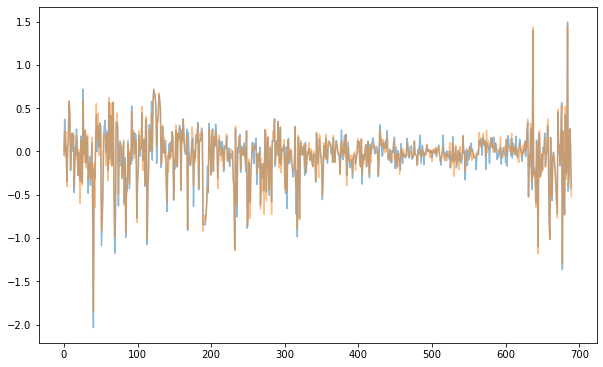

In [117]:
plt.plot(gamma_mode_24_random_first500[400], alpha=0.5)
plt.plot(gamma_mode_24_random_last500[400], alpha=0.5)

In [110]:
pre = "/Users/weilu/Research/server/nov_2020/curated_single_chain_optimization/optimization_msa_submode_24/gammas_random_last500//"
mode_24_random_last500 = get_A_B(pre, n=690)

In [111]:
A_B = mode_24_random_last500
cutoff_range=list(range(400, 700, 20)) 
gamma_mode_24_random_last500 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-60, cutoff_range=cutoff_range)

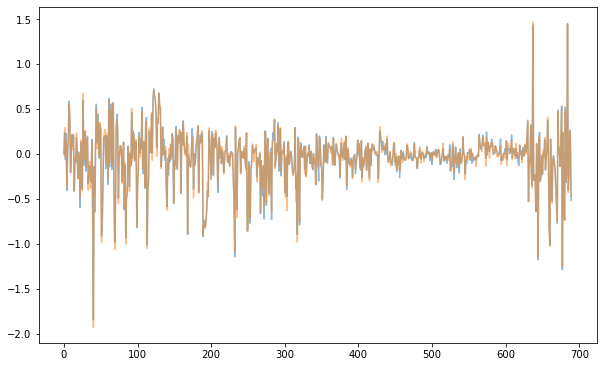

In [113]:
plt.plot(gamma_mode_24_random_last500[400], alpha=0.5)
plt.plot(gamma_mode_24_no_msa[400], alpha=0.5)

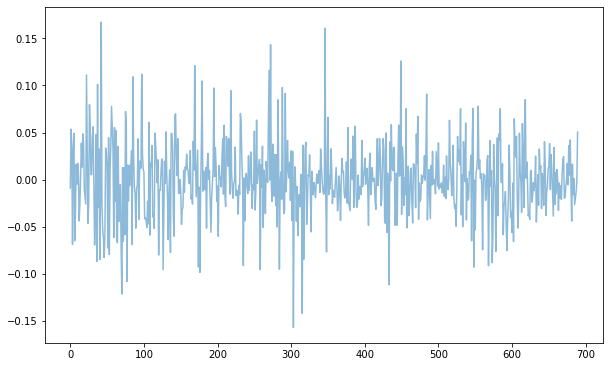

In [112]:
plt.plot(gamma_mode_24_no_msa[400] - gamma_mode_24_random_last500[400], alpha=0.5)

In [ ]:
pre = "/Users/weilu/Research/server/nov_2020/curated_single_chain_optimization/optimization_msa_submode_24/gammas_last500/"
mode_24_last500 = get_A_B(pre, n=690)

In [106]:
A_B = mode_24_last500
cutoff_range=list(range(400, 700, 20)) 
gamma_mode_24_last500 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-60, cutoff_range=cutoff_range)

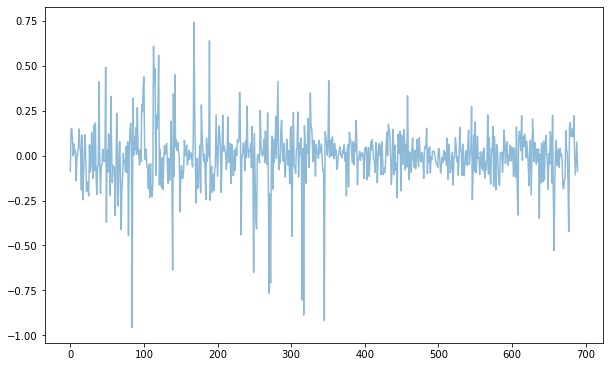

In [108]:
plt.plot(gamma_mode_24_last500[400] - gamma_mode_24_top500[400], alpha=0.5)

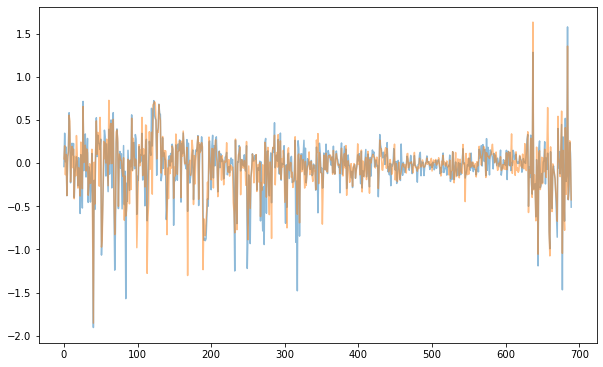

In [107]:
plt.plot(gamma_mode_24_last500[400], alpha=0.5)
plt.plot(gamma_mode_24_top500[400], alpha=0.5)

In [85]:
all_phis = np.load("/Users/weilu/Research/server/nov_2020/curated_single_chain_optimization/optimization_msa_submode_24/phis/2zqp_Y.npy")

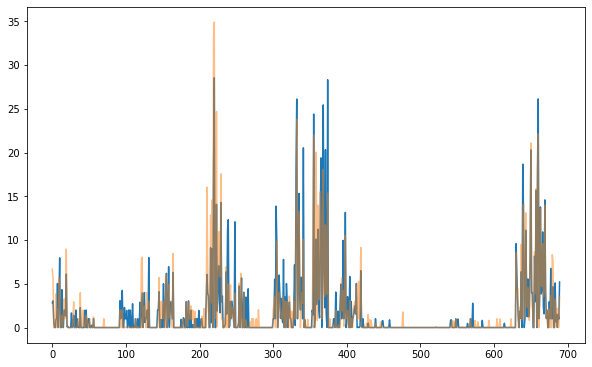

In [89]:
plt.plot(all_phis[0])
plt.plot(all_phis[1], alpha=0.5)

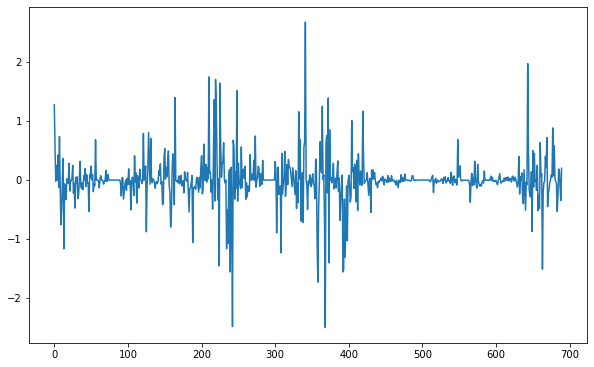

In [102]:
plt.plot(np.average(all_phis[:10], axis=0) - np.average(all_phis[:1000], axis=0))

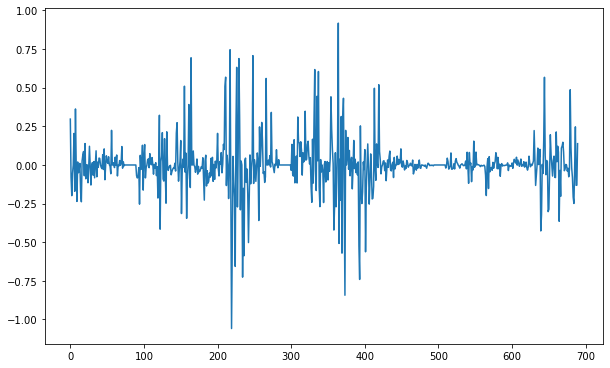

In [94]:
plt.plot(np.average(all_phis[:50], axis=0) - np.average(all_phis[:1000], axis=0))

## Mode 28, using just first 1, n_decoys 50

In [60]:
pre = "/Users/weilu/Research/server/nov_2020/curated_single_chain_optimization/optimization_msa_submode_28/gammas_only_one//"
mode_28_first1 = get_A_B(pre, n=690)

In [61]:
pre = "/Users/weilu/Research/server/nov_2020/curated_single_chain_optimization/optimization_msa_submode_24/gammas_only_one//"
mode_24_first1 = get_A_B(pre, n=690)

In [76]:
pre = "/Users/weilu/Research/server/nov_2020/curated_single_chain_optimization/optimization_msa_submode_25/gammas_only_one//"
mode_25_first1 = get_A_B(pre, n=690)

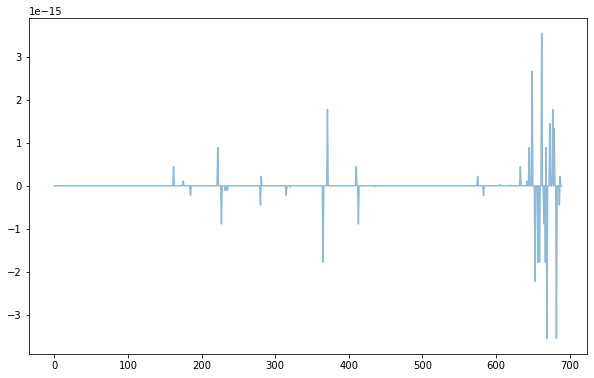

In [72]:
plt.plot((mode_28_first1['A'] - mode_28_first1['A_prime']) - (mode_24_first1['A'] - mode_24_first1['A_prime']), alpha=0.5)

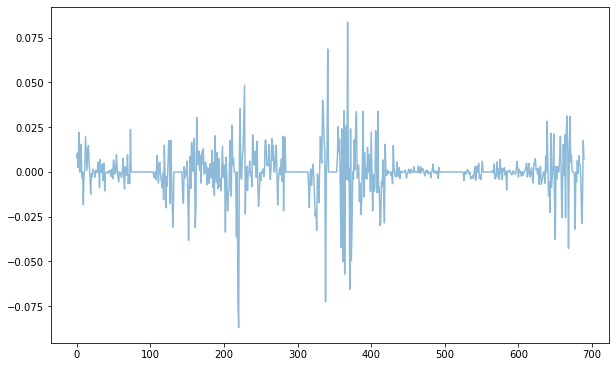

In [79]:
plt.plot(mode_25_first1['A_prime'] - mode_24_first1['A_prime'], alpha=0.5)

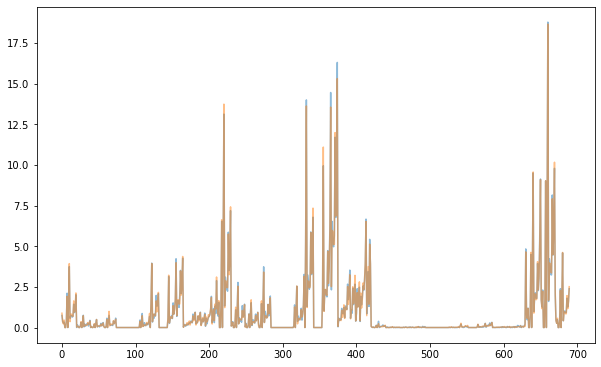

In [75]:
plt.plot(mode_28_first1['A_prime'], alpha=0.5)
plt.plot(mode_24_first1['A_prime'], alpha=0.5)
# plt.plot(mode_24_top500['A_prime'], alpha=0.5)
# plt.plot(mode_24_top500['A_prime'], alpha=0.5)

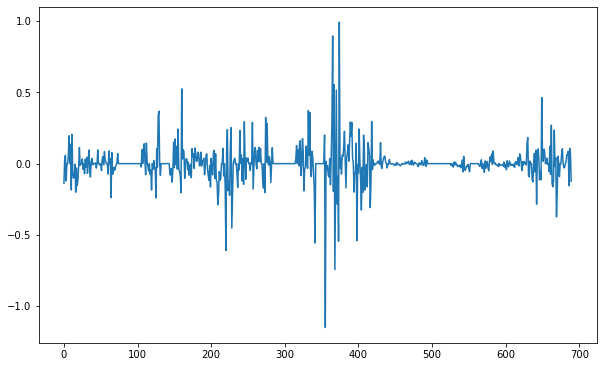

In [68]:
plt.plot(mode_28_first1['A_prime'] - mode_24_first1['A_prime'])

/Users/weilu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


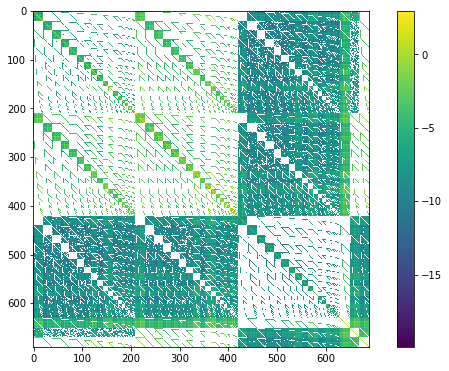

In [80]:
plt.imshow(np.log(mode_24_no_msa['B']))
plt.colorbar()

/Users/weilu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/Users/weilu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


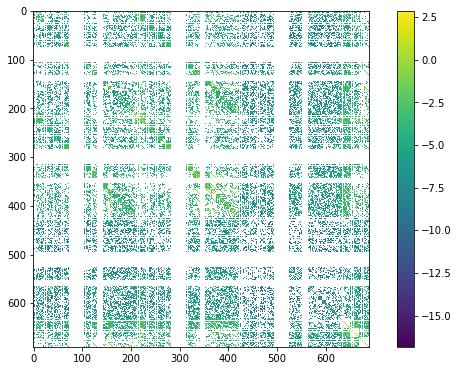

In [82]:
plt.imshow(np.log(mode_24_first1['B']))
plt.colorbar()

/Users/weilu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/Users/weilu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


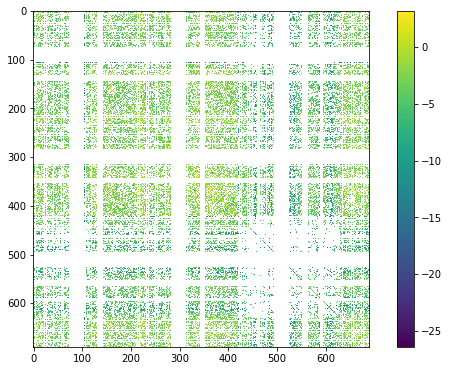

In [81]:
plt.imshow(np.log(mode_28_first1['B']))
plt.colorbar()

## Mode 28, using top 500, n_decoys 50

In [50]:
pre = "/Users/weilu/Research/server/nov_2020/curated_single_chain_optimization/optimization_msa_submode_28/gammas_first500/"
mode_28_top500 = get_A_B(pre, n=690)

In [51]:
A_B = mode_28_top500
cutoff_range=list(range(400, 700, 20)) 
gamma_mode_28_top500 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-60, cutoff_range=cutoff_range)

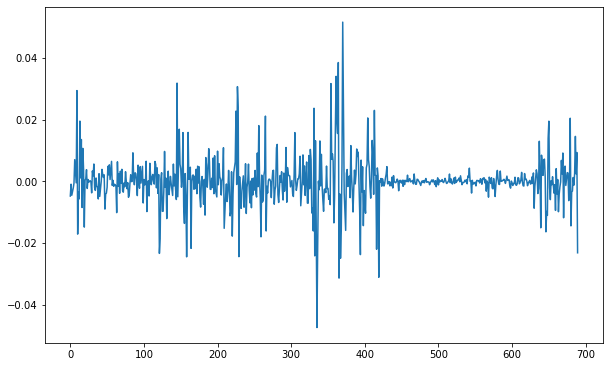

In [73]:
plt.plot(mode_28_top500['A_prime'] - mode_24_top500['A_prime'])
# plt.plot(, alpha=0.5)

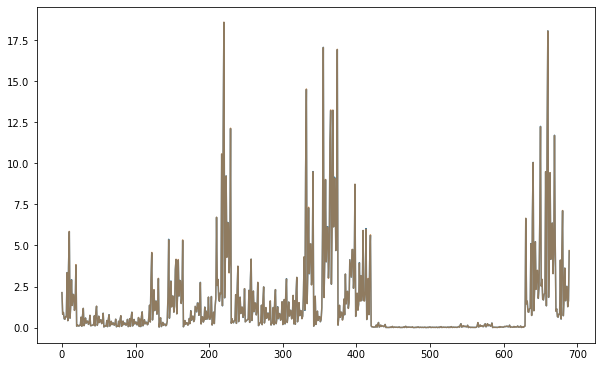

In [59]:
plt.plot(mode_28_top500['A_prime'])
plt.plot(mode_24_top500['A_prime'], alpha=0.5)

## Mode 25, using top 500, n_decoys 9000

In [39]:
pre = "/Users/weilu/Research/server/nov_2020/curated_single_chain_optimization/optimization_msa_submode_25/gammas_first500/"
mode_25_top500 = get_A_B(pre, n=690)

In [40]:
A_B = mode_25_top500
cutoff_range=list(range(400, 700, 20)) 
gamma_mode_25_top500 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-60, cutoff_range=cutoff_range)

/Users/weilu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


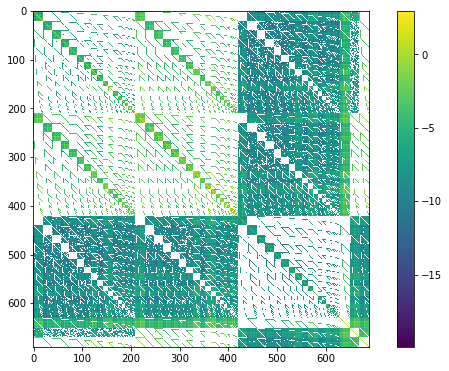

In [47]:
plt.imshow(np.log(mode_24_no_msa['B']))
plt.colorbar()

/Users/weilu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


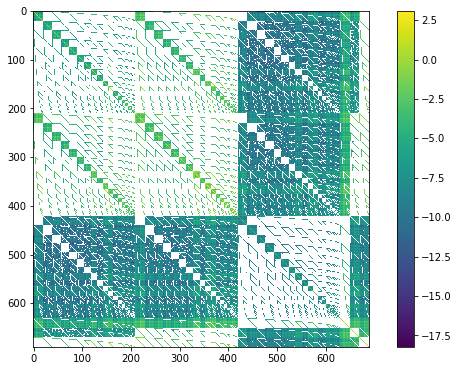

In [48]:
plt.imshow(np.log(mode_25_top500['B']))
plt.colorbar()

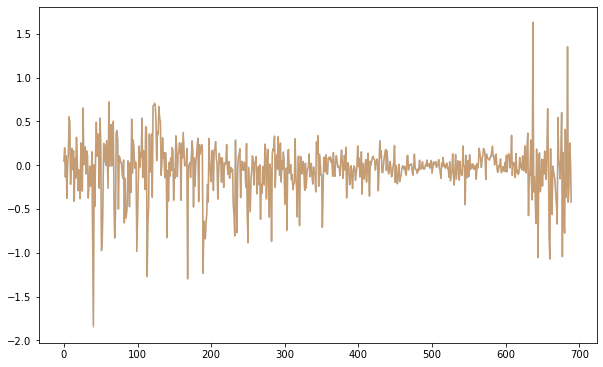

In [43]:
plt.plot(gamma_mode_25_top500[400], alpha=0.5)
plt.plot(gamma_mode_24_top500[400], alpha=0.5)

## Mode 24, using top 500, n_decoys 3000

In [33]:
pre = "/Users/weilu/Research/server/nov_2020/curated_single_chain_optimization/optimization_msa_submode_24/gammas_first500/"
mode_24_top500 = get_A_B(pre, n=690)

In [34]:
A_B = mode_24_top500
cutoff_range=list(range(400, 700, 20)) 
gamma_mode_24_top500 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-60, cutoff_range=cutoff_range)

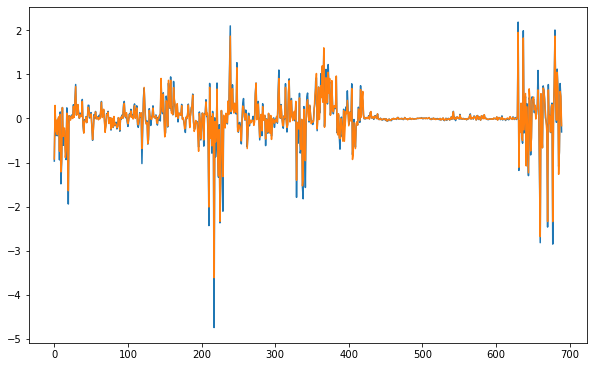

In [38]:
plt.plot(mode_24_top500['A'])
plt.plot(mode_24_no_msa['A'])

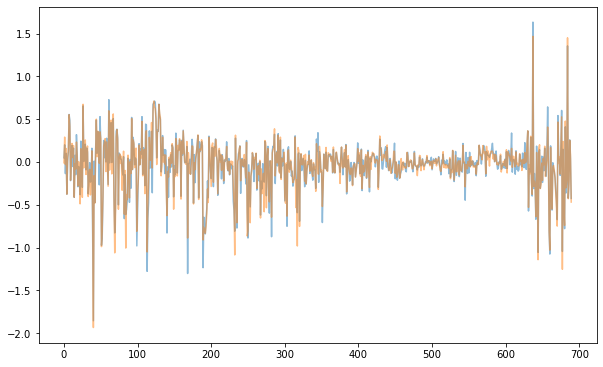

In [35]:
plt.plot(gamma_mode_24_top500[400], alpha=0.5)
plt.plot(gamma_mode_24_no_msa[400], alpha=0.5)

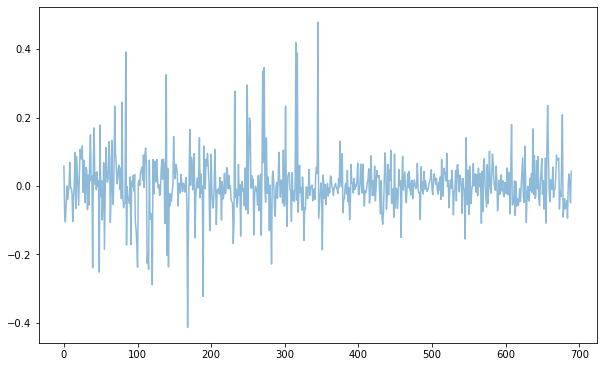

In [36]:
plt.plot(gamma_mode_24_top500[400] - gamma_mode_24_no_msa[400], alpha=0.5)
# plt.ylim(-2, 1.5)

# mode 26 will only use 1000 n_decoys. Let's see if this make a difference

# n_decoys = 1000 also works ok.
# I'm a bit worried. I want to try n_decoys = 200, will be mode 27
# n_decoys = 50, for mode 28

In [29]:
pre = "/Users/weilu/Research/server/nov_2020/curated_single_chain_optimization/optimization_msa_submode_28/gammas/"
mode_28_no_msa = get_A_B(pre, n=690)

In [30]:
A_B = mode_28_no_msa
cutoff_range=list(range(400, 700, 20)) 
gamma_mode_28_no_msa = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-60, cutoff_range=cutoff_range)

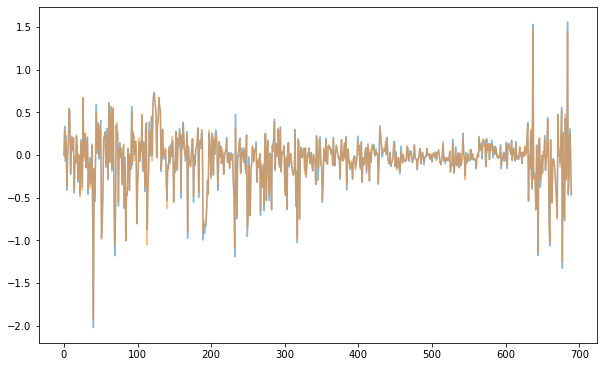

In [31]:
plt.plot(gamma_mode_28_no_msa[400], alpha=0.5)
plt.plot(gamma_mode_24_no_msa[400], alpha=0.5)

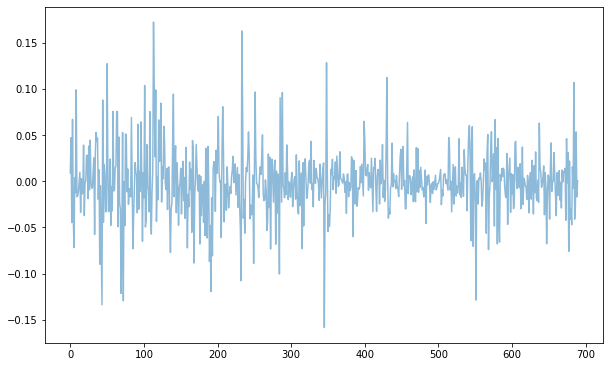

In [32]:
plt.plot(gamma_mode_28_no_msa[400] - gamma_mode_24_no_msa[400], alpha=0.5)
# plt.ylim(-2, 1.5)

In [22]:
pre = "/Users/weilu/Research/server/nov_2020/curated_single_chain_optimization/optimization_msa_submode_27/gammas/"
mode_27_no_msa = get_A_B(pre, n=690)

In [24]:
A_B = mode_27_no_msa
cutoff_range=list(range(400, 700, 20)) 
gamma_mode_27_no_msa = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-60, cutoff_range=cutoff_range)

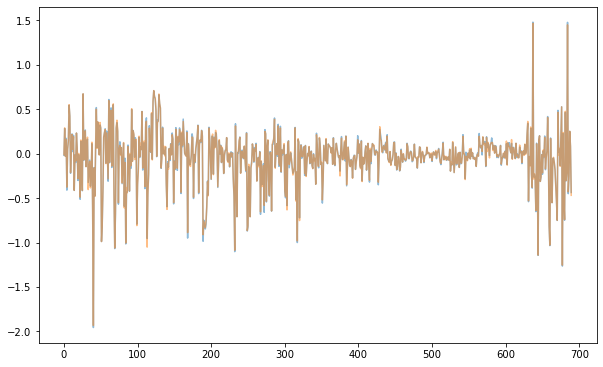

In [28]:
plt.plot(gamma_mode_27_no_msa[400], alpha=0.5)
plt.plot(gamma_mode_24_no_msa[400], alpha=0.5)

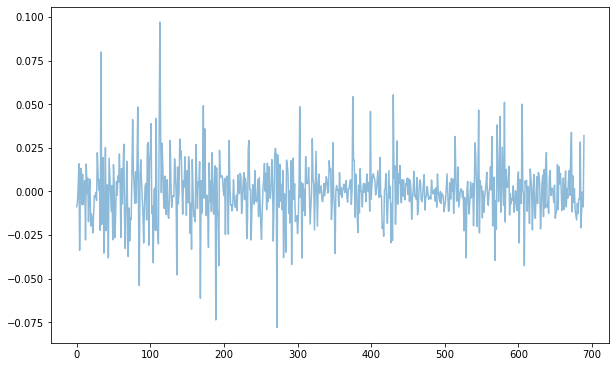

In [27]:
plt.plot(gamma_mode_27_no_msa[400] - gamma_mode_24_no_msa[400], alpha=0.5)
# plt.ylim(-2, 1.5)

In [14]:
pre = "/Users/weilu/Research/server/nov_2020/curated_single_chain_optimization/optimization_msa_submode_26/gammas/"
mode_26_no_msa = get_A_B(pre, n=690)

In [15]:
A_B = mode_26_no_msa
cutoff_range=list(range(400, 700, 20)) 
gamma_mode_26_no_msa = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-60, cutoff_range=cutoff_range)

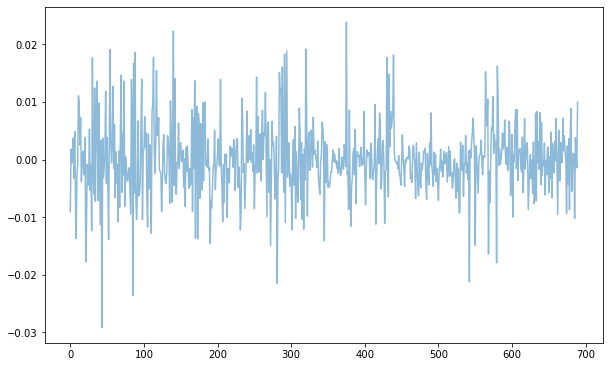

In [16]:
plt.plot(gamma_mode_26_no_msa[400] - gamma_mode_24_no_msa[400], alpha=0.5)
# plt.ylim(-2, 1.5)

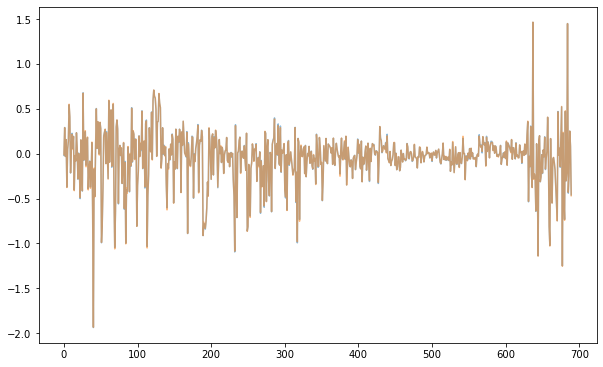

In [48]:
plt.plot(gamma_mode_26_no_msa[400], alpha=0.5)
plt.plot(gamma_mode_24_no_msa[400], alpha=0.5)

## also, N_decoys should be tested to see if make a different.
### right now,(mode 24) is using 3000.
### mode 25 will use 9000.

## They matched extremely well!

In [25]:
pre = "/Users/weilu/Research/server/nov_2020/curated_single_chain_optimization/optimization_msa_submode_25/gammas/"
mode_25_no_msa = get_A_B(pre, n=690)

In [26]:
A_B = mode_25_no_msa
cutoff_range=list(range(400, 700, 20)) 
gamma_mode_25_no_msa = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-60, cutoff_range=cutoff_range)

In [33]:
np.max(abs(mode_25_no_msa['A'] - mode_24_no_msa['A']))

0.003261144742912281

In [32]:
np.max(abs(mode_25_no_msa['B'] - mode_24_no_msa['B']))

0.038998702663121776

(-2, 1.5)

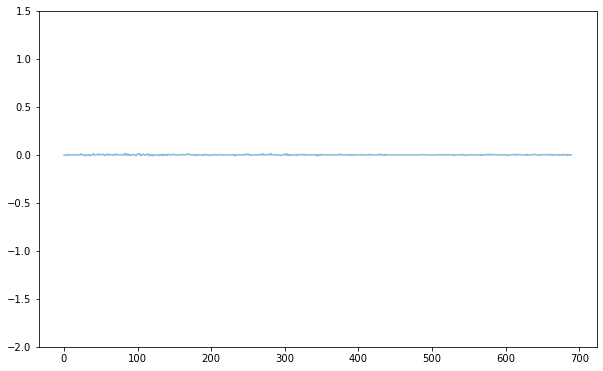

In [45]:
plt.plot(gamma_mode_25_no_msa[400] - gamma_mode_24_no_msa[400], alpha=0.5)
plt.ylim(-2, 1.5)

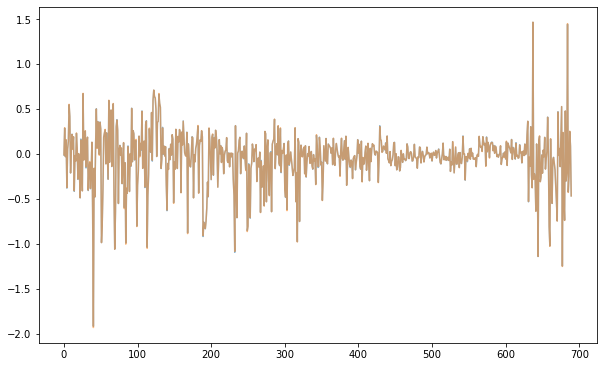

In [38]:
plt.plot(gamma_mode_25_no_msa[400], alpha=0.5)
plt.plot(gamma_mode_24_no_msa[400], alpha=0.5)

## Compare with with MSA, result is similar but not identical.

In [9]:
pre = "/Users/weilu/Research/server/nov_2020/curated_single_chain_optimization/optimization_msa_submode_24/gammas/"
mode_24_no_msa = get_A_B(pre, n=690)

In [10]:
A_B = mode_24_no_msa
cutoff_range=list(range(400, 700, 20)) 
gamma_mode_24_no_msa = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-60, cutoff_range=cutoff_range)

In [10]:
compare_mode24_400 = np.loadtxt("/Users/weilu/Research/server/nov_2020//membrane_protein_structure_prediction/gamma_folder/no_msa_contact.dat")

(-2, 1.5)

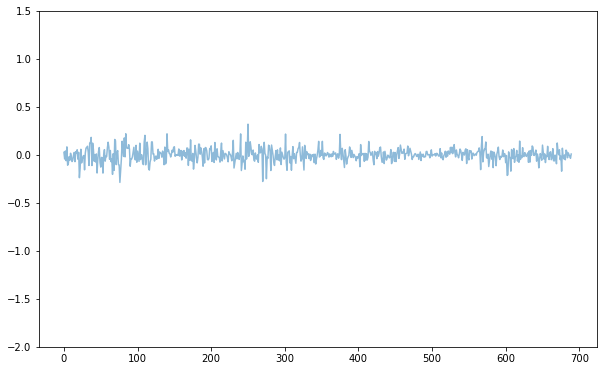

In [13]:
plt.plot(compare_mode24_400 - gamma_mode_24_no_msa[400], alpha=0.5)
plt.ylim(-2, 1.5)

In [14]:
compute_z(mode_24_no_msa, gamma_mode_24_no_msa[520])

6.234769148261692 6.171994637362831 38.48096174826639 -60.000000000000085


In [15]:
compute_z(mode_24_no_msa, gamma_mode_24_no_msa[400])

6.112430697152661 5.913264336027308 36.14441844791136 -60.00000000000005


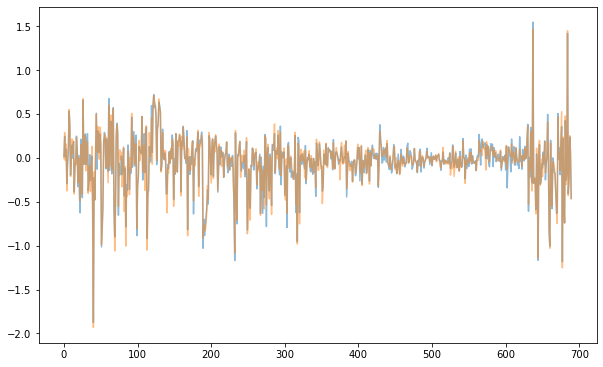

In [11]:
plt.plot(compare_mode24_400, alpha=0.5)
plt.plot(gamma_mode_24_no_msa[400], alpha=0.5)

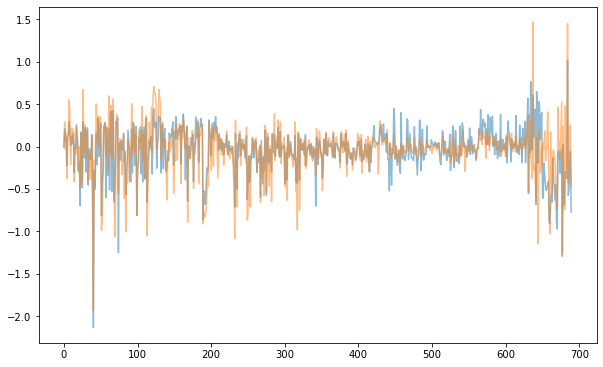

In [24]:
plt.plot(new_mode15_all_prime, alpha=0.5)
plt.plot(gamma_mode_24_no_msa[400], alpha=0.5)

(-2, 1.5)

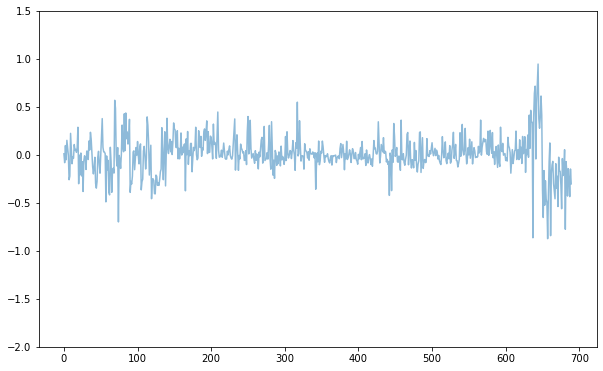

In [18]:
plt.plot(new_mode15_all_prime - gamma_mode_24_no_msa[400], alpha=0.5)
plt.ylim(-2, 1.5)

In [96]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_24/gamma/"
mode_24_no_msa = get_A_B(pre, n=690)

In [97]:
A_B = mode_24_no_msa
cutoff_range=list(range(400, 700, 20)) 
gamma_mode_24_no_msa = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-60, cutoff_range=cutoff_range)

In [125]:
np.savetxt("/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder/no_msa_contact.dat", gamma_mode_24_no_msa[400])

In [98]:
compute_z(mode_24_no_msa, gamma_mode_24_no_msa[520])

6.112902826926789 6.056930044845691 37.02542479363503 -59.99999999999992


In [123]:
compute_z(mode_24_no_msa, gamma_mode_24_no_msa[400])

5.994023040233341 5.798493175906359 34.75630169501852 -60.000000000000085


In [111]:
compute_z(mode_24_no_msa, gamma_mode15_new[520])

5.550257167635752 4.1682585050147685 23.1349066440169 -59.08224947822389


In [112]:
compute_z(mode_24_no_msa, gamma_mode15[520])

5.560566362821782 4.103425952649654 22.81737232463359 -68.84495488527705


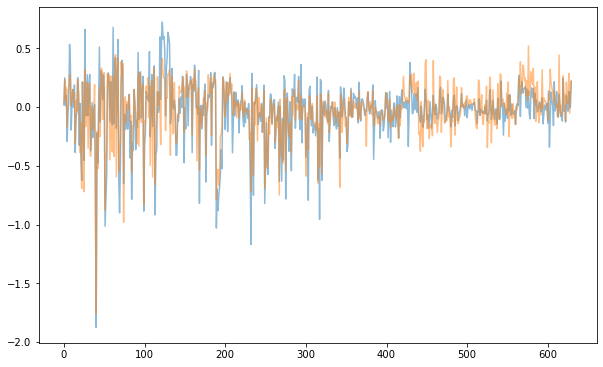

In [110]:
plt.plot(gamma_mode_24_no_msa[400][:630], alpha=0.5)
plt.plot(gamma_mode15_new[520][:630], alpha=0.5)

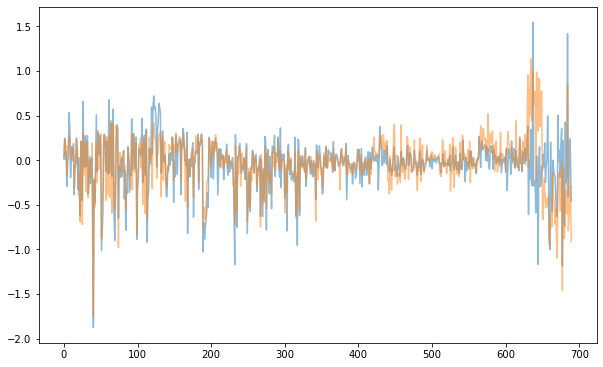

In [122]:
plt.plot(gamma_mode_24_no_msa[400], alpha=0.5)
plt.plot(gamma_mode15_new[520], alpha=0.5)

# using the whole protein aligments MSA

In [5]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_whole_protein_alignments_filtered_submode_15/gamma/"
mode_15_new = get_A_B(pre, n=690)

In [32]:
A_B = mode_15_new
A = A_B['A'][:630]
B = A_B['B'][:630,:630]
A_prime = A_B['A_prime'][:630]
cutoff_range=list(range(400, 620, 20)) 
gamma_mode15_new_630 = get_gamma(A, B, A_prime, c=-60, cutoff_range=cutoff_range)

In [33]:
compute_z(mode_15_new, gamma_mode15_new_630[520], n=630)

3.393762010361755 3.9172183681218633 13.294106884023249 -60.00000000000002


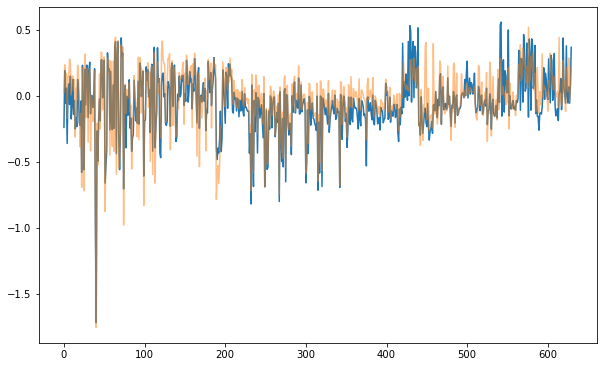

In [42]:
plt.plot(gamma_mode15_new_630[420])
plt.plot(gamma_mode15_new[520][:630], alpha=0.5)

In [20]:
A_B = mode_15_new
cutoff_range=list(range(400, 700, 20)) 
gamma_mode15_new = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-60, cutoff_range=cutoff_range)

In [21]:
compute_z(mode_15_new, gamma_mode15_new[520])

4.525820041447532 4.627205736085739 20.941900456277818 -59.99999999999998


In [16]:
compute_z(mode_15, gamma_mode15[520])

4.640464057648172 4.608435332275099 21.38527852141851 5.906386491005833e-14


In [113]:
compute_z(mode_15, gamma_mode_24_no_msa[520])

1.5917318898008332 15.919525187398268 25.33961591126941 -59.08034738573564


In [124]:
compute_z(mode_15, gamma_mode_24_no_msa[400])

2.986270169028445 8.07119213439603 24.10276029944389 -58.34737008960441


In [114]:
compute_z(mode_15_new, gamma_mode_24_no_msa[520])

1.5654420185091413 16.417228390886425 25.700219150554826 -62.998108228917864


In [17]:
compute_z(mode_15, gamma_mode15_new[520])

4.554931617812581 4.611064147582451 21.003081877585327 3.1132880118143187


In [18]:
compute_z(mode_15_new, gamma_mode15[520])

4.532176363619909 4.607859030792466 20.883629786250157 -3.5623382253628257


In [19]:
compute_z(mode_15, gamma_mode15[600])

4.671590228724875 4.640578432327143 21.678880860090878 -8.570921750106208e-14


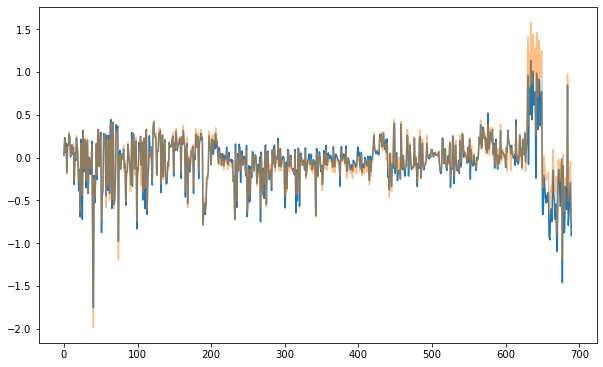

In [22]:
plt.plot(gamma_mode15_new[520][:690])
plt.plot(gamma_mode15[520][:690], alpha=0.5)

In [ ]:
compute_z(A_B, gamma)

In [95]:
compute_z(mode_15_new, gamma_mode15[520])

4.425550193470743 4.66157038140345 20.630013703297525 -69.90333845815951


## mode 15 repeats mode 9 (contact term only), but with bug-fixed

In [91]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_15/gamma/"
mode_15 = get_A_B(pre, n=690)

A_B = mode_15
cutoff_range=list(range(400, 700, 10)) 
gamma_mode15 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-66, cutoff_range=cutoff_range)

In [92]:
compute_z(mode_15, gamma_mode15[520])

4.5430025642731655 4.653612650098108 21.141374202529743 -65.99999999999991


In [87]:
compute_z(mode_15, gamma_mode15[520])

4.640464057648172 4.608435332275099 21.38527852141851 5.906386491005833e-14


In [90]:
compute_z(mode_15, gamma_mode15[580])

4.662830001034646 4.629355635824828 21.585898344182826 -9.325873406851315e-15


Text(0.5, 1.0, 'sorted eigenvalues of B matrix in log scale')

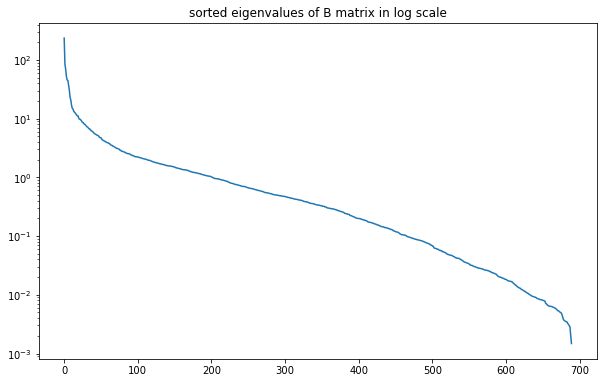

In [71]:
B = mode_15['B']
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
plt.plot(lamb)
plt.yscale("log")
plt.title("sorted eigenvalues of B matrix in log scale")

/Users/weilu/anaconda/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'sorted eigenvalues of B matrix in log scale')

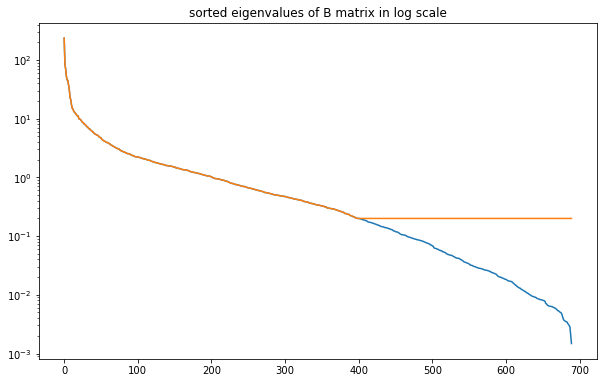

In [74]:
B_new = filter_B_matrix(B, 500)
B = B_new
lamb_new, P_new = np.linalg.eig(B_new)
lamb_new, P_new = sort_eigenvalues_and_eigenvectors(lamb_new, P_new)
plt.plot(lamb)
plt.plot(lamb_new)
plt.yscale("log")
plt.title("sorted eigenvalues of B matrix in log scale")

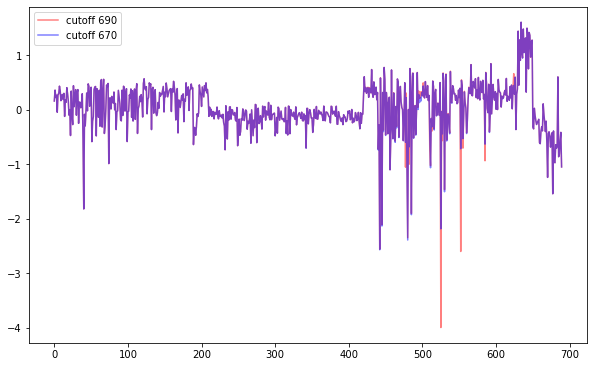

In [86]:
plt.plot(gamma_mode15[690][:690], alpha=0.5, label="cutoff 690", c="red")
plt.plot(gamma_mode15[670][:690], alpha=0.5, label="cutoff 670", c="blue")
# plt.plot(gamma_mode15[680][:690], alpha=0.5, label="cutoff 680", c="blue")
plt.legend()

In [ ]:
filter_B_matrix(B, cutoff)

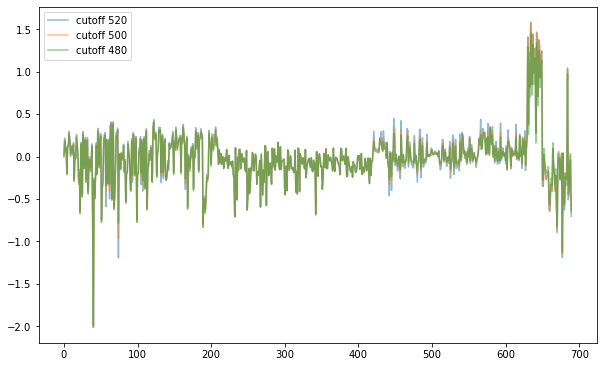

In [82]:
plt.plot(gamma_mode15[520][:690], alpha=0.5, label="cutoff 520")
plt.plot(gamma_mode15[500][:690], alpha=0.5, label="cutoff 500")
plt.plot(gamma_mode15[480][:690], alpha=0.5, label="cutoff 480")
# plt.plot(gamma_mode15[400][:690], alpha=0.5, label="cutoff 400")
plt.legend()
# plt.plot(gamma_mode16[722][:690], alpha=0.5)
# plt.plot(gamma_mode15[520][:690])

In [44]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode15[520]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

4.532176363619909 4.607859030792466 20.883629786250157 -3.5623382253628257


In [30]:
B = mode_15['B']
cutoff = 520
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
filtered_lamb = np.copy(lamb)
cutoff_mode = cutoff
filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                   cutoff_mode, P)
B_new = np.linalg.inv(filtered_B_inv)

In [75]:
from cvxopt import matrix, solvers
A_B = mode_15
# B = A_B['B']
B = B_new
A = A_B['A']
A_prime = A_B['A_prime']
n = len(A_prime)

Q = 2*matrix(B)
p = matrix(np.zeros(n))
# G = matrix(-A, (1,n))
# h = matrix(-7.117566, (1, 1), 'd')
additional_constraint = np.diag([-1]*n)
additional_constraint = A_B_6nq0_A['A_prime'].reshape(1,n)
additional_constraint = a_prime_all
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n,n))
# h = matrix([-21, -0]+[15]*n, (2+n, 1), 'd')
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+1,n))
# h = matrix([-21, -0]+[-0], (2+1, 1), 'd')
n_additional_constraint = additional_constraint.shape[0]
G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n_additional_constraint,n))
h = matrix([-21, -0]+[-0]*n_additional_constraint, (2+n_additional_constraint, 1), 'd')
sol=solvers.qp(Q, p, G=G, h=h)
x = np.array(sol['x']).flatten()

     pcost       dcost       gap    pres   dres
 0:  2.6911e+01  1.1442e+02  2e+04  1e+01  2e+05
 1:  5.8358e+01 -2.1890e+03  3e+03  2e+00  2e+04
 2:  3.4914e+01 -3.8051e+02  4e+02  2e-01  3e+03
 3:  2.7041e+01 -5.1661e+01  8e+01  4e-02  6e+02
 4:  2.5327e+01  5.3632e+00  2e+01  1e-02  1e+02
 5:  2.4482e+01  1.8007e+01  6e+00  3e-03  4e+01
 6:  2.4024e+01  2.0099e+01  4e+00  2e-03  2e+01
 7:  2.3816e+01  2.0166e+01  4e+00  1e-03  2e+01
 8:  2.3373e+01  2.1974e+01  1e+00  5e-04  7e+00
 9:  2.3148e+01  2.1622e+01  2e+00  4e-04  5e+00
10:  2.2864e+01  2.1785e+01  1e+00  2e-04  3e+00
11:  2.2550e+01  2.2311e+01  2e-01  5e-05  7e-01
12:  2.2519e+01  2.2515e+01  4e-03  4e-07  6e-03
13:  2.2519e+01  2.2519e+01  4e-05  4e-09  6e-05
14:  2.2519e+01  2.2519e+01  4e-07  4e-11  6e-07
15:  2.2519e+01  2.2519e+01  4e-09  5e-13  6e-09
Optimal solution found.


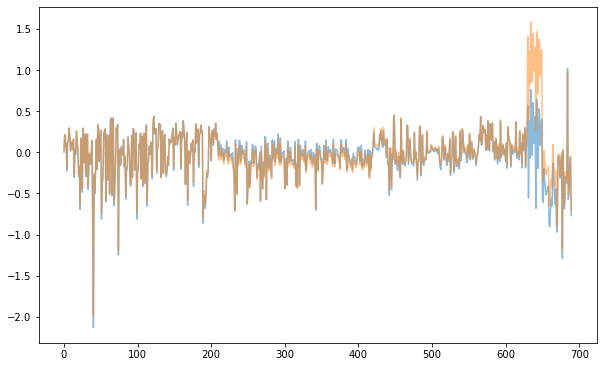

In [76]:
plt.plot(x, alpha=0.5)
plt.plot(gamma_mode15[520][:690], alpha=0.5)

In [73]:
# import glob
# ab_list = glob.glob("/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_15/A_B_dic/*.npy")
# a_prime_all = np.zeros((len(ab_list), 690))
# for abFile in ab_list:
#     A_B_one = np.load(abFile, allow_pickle=True).item()
#     a_prime_all = A_B_one["A_prime"]

abFile = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_15/a_prime_all.npy"
a_prime_all = np.load(abFile, allow_pickle=True)

In [74]:
a_prime_all

array([[1.87679006, 1.1369308 , 1.0812917 , ..., 1.23074547, 2.02222888,
        4.99261131],
       [4.85276668, 1.58350866, 1.40217948, ..., 1.84914302, 2.70250495,
        8.75344392],
       [0.9882021 , 0.60782271, 0.40400915, ..., 1.40091433, 1.79943992,
        3.7836284 ],
       ...,
       [0.39029175, 0.2278609 , 0.14997577, ..., 0.15530463, 0.06551744,
        0.62402178],
       [1.38424566, 1.25354991, 1.09497621, ..., 0.87404378, 1.34934104,
        2.70164878],
       [1.47953867, 0.79072309, 0.3829428 , ..., 1.34111058, 1.94186277,
        3.80409148]])

In [77]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722][:690]
# x = gamma_mode15[520]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

4.44948869404758 4.719643411633881 21.000000000001105 -66.08984543497455


In [78]:
np.savetxt("/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder/new_mode15_all_prime.dat", x)

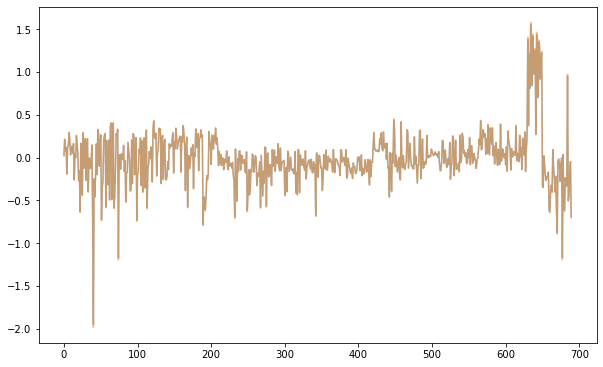

In [44]:
plt.plot(x, alpha=0.5)
plt.plot(gamma_mode15[520][:690], alpha=0.5)

In [4]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_16/gamma/"
mode_16 = get_A_B(pre, n=2022)

In [5]:
A_B = mode_16
cutoff_range=list(range(522, 2122, 100)) 
gamma_mode16 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-0, cutoff_range=cutoff_range)

In [8]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
x = gamma_mode16[722]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

5.006197747326388 4.816455992909468 24.11213114180006 2.372545519421787e-13


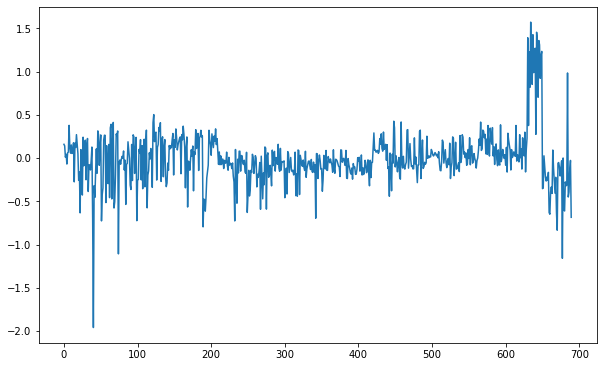

In [6]:
plt.plot(gamma_mode16[722][:690])

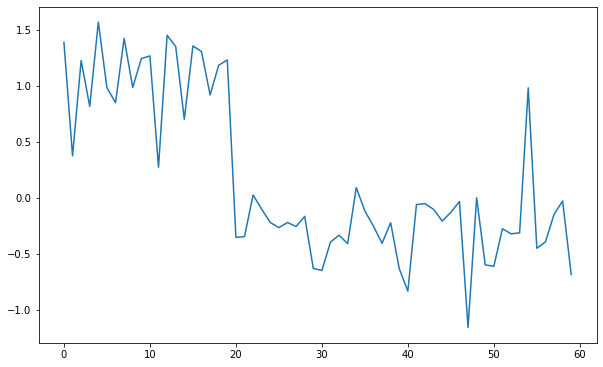

In [9]:
plt.plot(gamma_mode16[722][630:690])

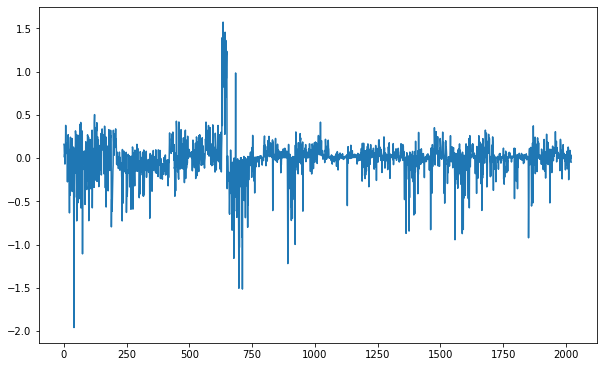

In [7]:
plt.plot(gamma_mode16[722])

In [10]:
toLocation = "/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder"
np.savetxt(f"{toLocation}/complete_cutoff722_contact_part_oct11.dat", x[:690])
np.savetxt(f"{toLocation}/complete_cutoff722_fourBody_part_oct11.dat", -x[690:])
np.savetxt(f"{toLocation}/complete_cutoff722_all_part_oct11.dat", x)

In [12]:
A_B["A_prime"].dot(gamma_mode16[722])

2.372545519421787e-13